In [5]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation as ani
import itertools

import pygraphviz as pgv
import copy
import pickle

In [6]:
#%matplotlib inline
%matplotlib notebook

# Step 1: Generate Graph
- The graph is simulated at the household level. 

In [112]:
# Parameters
num_families = 250
family_sizes = np.random.choice(range(1,8), size=num_families, p=[.2837, .3451, .1507, .1276, .0578, .0226, 0.0125])
age_groups_probs = [0.248, 0.577, 0.175] # Children, adults, elderly/retired

infectivity = 0.33
days_incubating = 1
days_presymptomatic = 3
days_symptomatic = 4
num_to_seed = 5

# Work/School parameters
num_schools = 2
num_workplaces = 15
prop_essential = 0.1

# Social parameters
large_gathering_count_mean = 4.5  # Using a poisson distn, the mean number of large gatherings per time period
large_gathering_size_mean = 7 # Using a poisson distn, the mean number of people at these gatherings 
solo_gatherings_prob = 0.07 # The probability of a one-on-one interactions per time period

# Every time period, the probability of a given work or school connection being active
inst_school_connection_prob = 0.02
inst_work_connection_prob = 0.03

time_delta = 60 # In minutes 
num_weeks = 4

age_colors = {0:'#02c26f', 1:'#0379ff', 2:'#bd08ff'} 

In [159]:
G = nx.Graph()

families = {}
all_colors = []

person_idx = 0

children = []
adults = []
elderly = []
person_to_family = {}


family_edges = []

for family_idx in range(num_families):
    fam_size = family_sizes[family_idx]
    persons = list(range(person_idx, person_idx+fam_size))
    
    # No children alone, more people -> higher chance of children
    num_children = np.random.binomial(n=fam_size-1, p=age_groups_probs[0]+(fam_size*0.04))
    num_elderly = np.random.binomial(n=fam_size-num_children, p=age_groups_probs[2]+0.02)
    num_adults = fam_size-num_children-num_elderly
        
    # Add the person ids to list for each age group
    children += persons[:num_children]
    adults += persons[num_children:num_children+num_adults]
    elderly += persons[num_children+num_adults:]
    
    # Map each person id to the family id
    person_to_family.update({pid:family_idx for pid in persons})
    

    families[family_idx] = {'size': fam_size,
                            'persons': persons
                           }
    person_idx += fam_size
    
    G.add_nodes_from(children, age='child', family=family_idx)
    G.add_nodes_from(adults, age='adult', family=family_idx)
    G.add_nodes_from(elderly, age='elderly', family=family_idx)
    
    family_edges += itertools.combinations(persons, 2)
    all_colors += [age_colors[0]]*num_children + [age_colors[1]]*num_adults + [age_colors[2]]*num_elderly
    
children_family_edges = np.array([i for i in family_edges if (i[0] in set(children))|(i[1] in set(children))])   
adult_family_edges = np.array([i for i in family_edges if (i[0] in set(adults))|(i[1] in set(adults))]) 
family_edges = np.array(family_edges)
    
G.add_edges_from(family_edges, reason='family')
positions = graphviz_layout(G, prog='neato')

In [160]:
print('Children: {}, Adults: {}, Elderly {}'.format(len(children), len(adults), len(elderly)))
total = len(children)+len(elderly)+len(adults)
print("Proportions: Children {:.2f}, Adults {:.2f}, Elderly {:.2f}"\
          .format(len(children)/total, len(adults)/total, len(elderly)/total))
print()
print('Persons per work: {}'.format(round(len(adults)/num_workplaces)))
print('Children per school: {}'.format(round(len(children)/num_schools)))

Children: 155, Adults: 367, Elderly 95
Proportions: Children 0.25, Adults 0.59, Elderly 0.15

Persons per work: 24
Children per school: 78


<IPython.core.display.Javascript object>


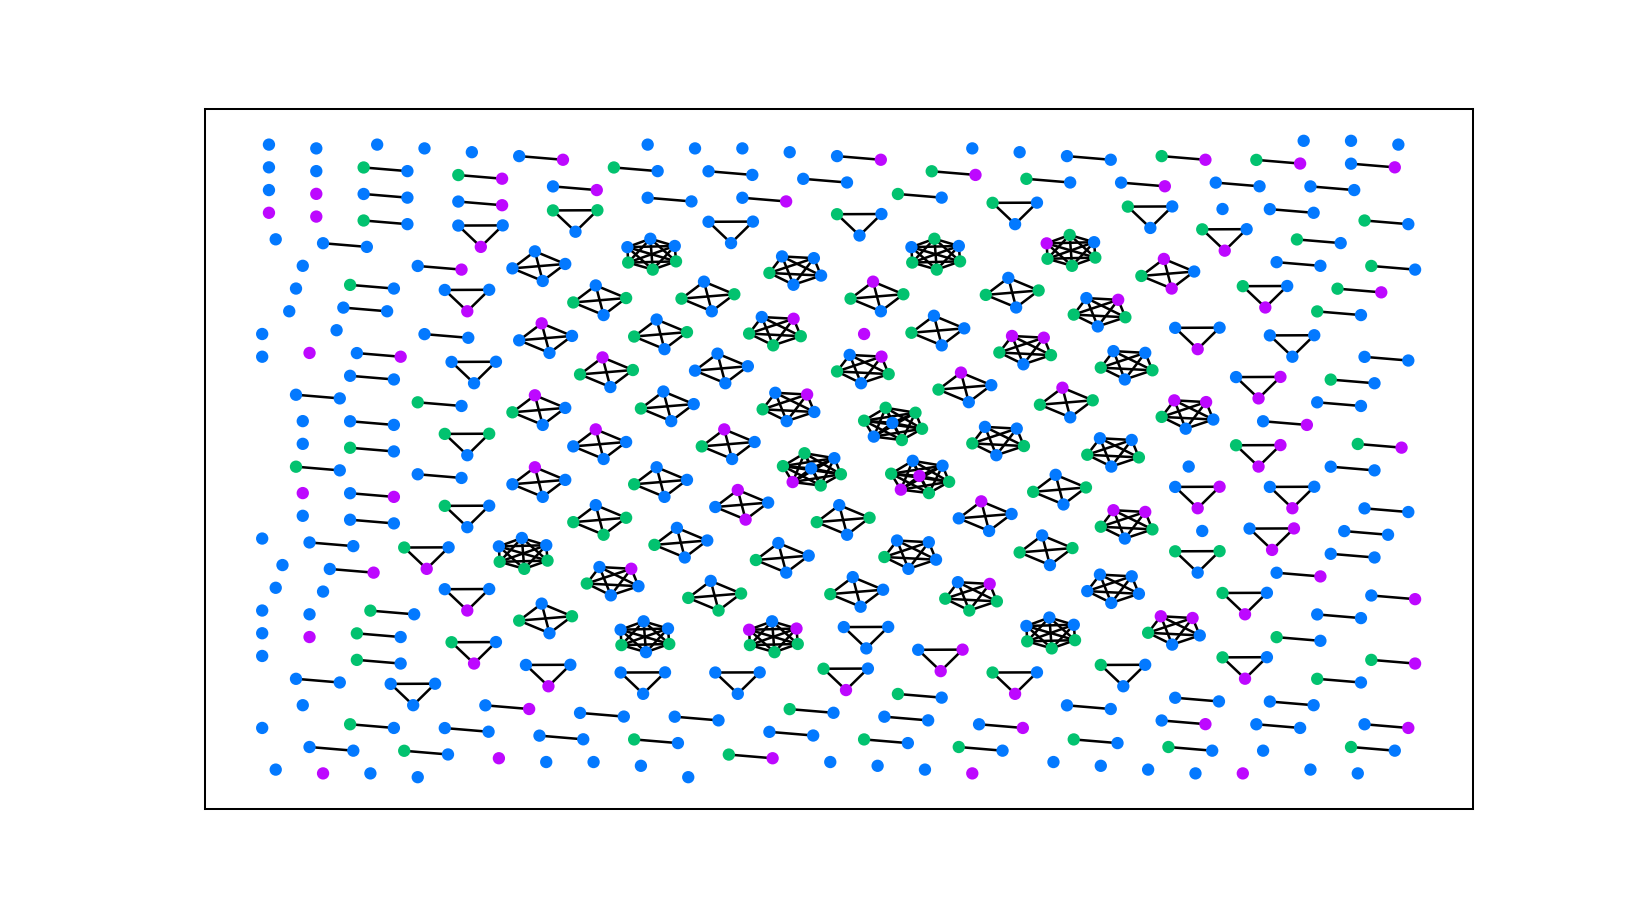

In [161]:
plt.figure(1,figsize=(9,5)) 
nx.draw_networkx(G, pos=positions, node_color=all_colors, node_size=15, with_labels=False)

# Step 2: Gather Group Edges

In [162]:
def chunks(l, n):
    """Yield n number of striped chunks from l."""
    for i in range(0, n):
        yield l[i::n]

def gen_school_edges(children, num_schools):
    """
    Return a list of all the edges for schools
    """
    #     if (day is in ('saturday', 'sunday')) | (time < 8) | (time >= 15):
    #         return 
    schools = chunks(children, num_schools)
    
    all_edges = []
    for school in schools:
        edges = itertools.combinations(school, 2)
        all_edges += edges
        
    return np.array(all_edges)


def gen_work_edges(adults, num_workplaces, prop_essential):
    """
    Creates all the connections for the workplaces, divided into nonessential and essential workplaces
    """
    workplaces = chunks(adults, num_workplaces)
    num_essential = round(int(num_workplaces*prop_essential))
    
    non_essential_edges = []
    essential_edges = []
    
    for i, workplace in enumerate(workplaces):
        edges = itertools.combinations(workplace, 2)
        
        if i < num_essential:
            essential_edges += edges
        else:
            non_essential_edges += edges
    
    return np.array(non_essential_edges), np.array(essential_edges)

In [163]:
school_edges = gen_school_edges(children, num_schools)
non_essential_edges, essential_edges = gen_work_edges(adults, num_workplaces, prop_essential)

In [164]:
### Calculate how many interactions people have on average

schools_mask = np.random.binomial(1, inst_school_connection_prob, len(school_edges))
schools_samp = school_edges[schools_mask.astype(bool)]
counts = {i:0 for i in children}
for i in schools_samp.flatten():
    counts[i] += 1
print("School interactions per person, per day: {}".format(sum(counts.values())/len(children) * (8*(60/time_delta))))


work_mask = np.random.binomial(1, inst_work_connection_prob, len(essential_edges)+len(non_essential_edges))
work_samp = np.concatenate((essential_edges,non_essential_edges), axis=0)[work_mask.astype(bool)]
counts = {i:0 for i in adults}
for i in work_samp.flatten():
    counts[i] += 1
print("Work interactions per person, per day: {}".format(sum(counts.values())/len(adults) * (8*(60/time_delta))))

School interactions per person, per day: 11.870967741935484
Work interactions per person, per day: 5.231607629427793


# Step 3: Simulate

In [213]:
def calc_time_delta(time_tup_start, time_tup_end):
    """
    Calculate the number of days between two time tuples of the form (day, hour)
    """
    day_start, hour_start = time_tup_start
    day_end, hour_end = time_tup_end
    
    return ((day_end*24 + hour_end)-(day_start*24 + hour_start))/24


def get_num_timesteps(num_weeks, time_delta):
    """
    Get the total number of timesteps there will be, for setting the lineplot axes
    """
    start_hour = 7
    end_hour = 20
    
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
    return num_weeks*len(days)*len(range(start_hour, end_hour+1))*len(range(0,60,time_delta))


def gen_daytime(num_weeks, time_delta):
    """
    Generator for animation
    """
    # Start at 7am and end at 10pm
    start_hour = 7
    end_hour = 20
    
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        
    step = -1
    for week in range(num_weeks):
        for i, day in enumerate(days):
            for hour in range(start_hour, end_hour+1):
                for minute in range(0,60,time_delta):
                    day_num = week*len(days) + i
                    step += 1
                    yield (week, day, day_num, hour, minute, step)

                    
def clear_all_node_attributes(network, attribute_names):
    """
    For clearing out all attributes without deleting the graph
    """
    for attr_name in attribute_names:
        nodes = nx.get_node_attributes(network, attr_name).keys()
        
        for node in nodes:
            del network.node[node][attr_name]
            
    return network
    

def timestep(G, day, hour, minute,  day_num, run_id,
             schools_bool, work_type, group_social_prop, solo_social_prop, 
             incubating, presymp, symp, recovered
            ):
    """
    Based on the time, day of week, and configurables, generate the graph at a certain time
    """
    ###### Turn on schools halfway through
    if day_num >= 14: schools_bool = True
    #####
    
    
    weekend_bool = day in ('Saturday', 'Sunday')
    time = hour + minute/60
    
    # Setting (or altering) our parameters based on time and day of week. We still want the options above to run as 
    # expected however, requiring some careful settings 
    if time < 9: # Before the workday
        schools_bool = False
        work_type = 'none'
        social_bool = False
    
    elif (time >= 9) & (time < 17): # During the workday
        if weekend_bool: # Weekend
            schools_bool = False
            work_type = 'none'
            social_bool = True
        else: # Weekday
            social_bool = False
        
    else: # After work
        schools_bool = False
        work_type = 'none'
        social_bool = True
            
    #### Determining connections based on time of day
    # Schools
    if schools_bool:
        G.remove_edges_from(school_edges)  # Clear the previous random selection
        schools_mask = np.random.binomial(1, inst_school_connection_prob, len(school_edges))
        schools_samp = school_edges[schools_mask.astype(bool)]
        G.remove_edges_from(children_family_edges)
        G.add_edges_from(schools_samp, reason='school')
    else:
        G.remove_edges_from(school_edges)
        G.add_edges_from(children_family_edges, reason='family')
    
    # Work
    all_jobs = np.concatenate((essential_edges,non_essential_edges), axis=0)
    if work_type == 'none':
        G.remove_edges_from(all_jobs)
        G.add_edges_from(adult_family_edges, reason='family')
    elif work_type == 'essential':
        G.remove_edges_from(all_jobs)
        essential_mask = np.random.binomial(1, inst_work_connection_prob, len(essential_edges))
        essential_samp = essential_edges[essential_mask.astype(bool)]
        G.add_edges_from(essential_samp, reason='work')
        G.add_edges_from(adult_family_edges, reason='family') # For performance, just add all family edges ¯\_(ツ)_/¯ 
    else:
        G.remove_edges_from(all_jobs)
        G.remove_edges_from(adult_family_edges)
        work_mask = np.random.binomial(1, inst_work_connection_prob, len(all_jobs))
        work_samp = all_jobs[work_mask.astype(bool)]
        G.add_edges_from(work_samp, reason='work')
    if schools_bool:
        G.remove_edges_from(children_family_edges) # Some connections might have been reintroduced from jobs
    
    # Social Gatherings
    reasons = nx.get_edge_attributes(G,'reason')
    G.remove_edges_from([edge for edge, reason in reasons.items() if 'social' in reason]) # Remove old edges
    if social_bool:
        # Model large gatherings
        num_gatherings = np.random.poisson(lam=large_gathering_count_mean*group_social_prop)
        
        for gathering in range(num_gatherings):
            num_people = np.random.poisson(lam=large_gathering_size_mean)
            attendees = np.random.choice(large_gath_cand, size=num_people, replace=False) \
                                         if len(large_gath_cand)>0 else []
                
            # to track how many each person attended
            for i in attendees:
                large_gath_cand_dict[i] +=1
            
            # Link all the attendees
            links = itertools.combinations(attendees, 2)
            G.add_edges_from(links, reason='social_large')
            
        # Model small gatherings
        small_social_mask = np.random.binomial(1, solo_gatherings_prob, len(solo_cand))
        small_social_people = solo_cand[small_social_mask.astype(bool)]
        pairs = [(small_social_people[2*i], small_social_people[2*i+1]) for i in range(len(small_social_people)//2)]
        G.add_edges_from(pairs, reason='social_small')
        
        # to track how many each person attended
        for i in small_social_people:
            solo_cand_dict[i] +=1
    
    #### Calculate Infection Spread
    infection_sources = {'social_large':0, 'work':0, 'school':0, 'family':0, 'social_small':0}
    
    # Incubating 
    incubating_to_remove = set()
    for person in incubating:  # Non-infectious, yet
        if calc_time_delta(G.node[person]['time'], (day_num,hour)) > days_incubating:
            nx.set_node_attributes(G, {person:{'time':(day_num, hour)}}) # Store their time of change
            incubating_to_remove.add(person)
            presymp.add(person) 
            
    for i in incubating_to_remove:  # Cannot remove with .difference because operation must be in-place 
        incubating.remove(i)
    
    # Presymptomatic 
    presymp_to_remove = set()
    for person in presymp:
        # Change to symptomatic after delay
        if calc_time_delta(G.node[person]['time'], (day_num,hour)) > days_presymptomatic:
            nx.set_node_attributes(G, {person:{'time':(day_num, hour)}}) # Store their time of change
            presymp_to_remove.add(person)
            symp.add(person)
        else:
            # Ranomly infect neighbors
            for neig in G.neighbors(person):
                if (np.random.uniform() < infectivity) & \
                        (neig not in presymp) & \
                        (neig not in symp) & \
                        (neig not in incubating) & \
                        (neig not in recovered):
                    reason = G.get_edge_data(person, neig)['reason']
                    infection_sources[reason] += 1
                    incubating.add(neig)
                    nx.set_node_attributes(G, {neig:{'time':(day_num,hour)}})
    
    for i in presymp_to_remove:  # Cannot remove with .difference because operation must be in-place 
        presymp.remove(i)
    
    # Symptomatic
    symp_to_remove = set()
    for person in symp:
        # Add to recovered after delay
        if calc_time_delta(G.node[person]['time'], (day_num,hour)) > days_symptomatic:
            del G.node[person]['time']
            recovered.add(person)
            symp_to_remove.add(person)
        else:
            # Quarantine the entire family (all connections but family are removed)
            family_id = person_to_family[person]
            all_fam_members = families[family_id]['persons']
            for fam_member in all_fam_members:
                G.remove_edges_from([(fam_member, n) for n in G.neighbors(fam_member)])
            G.add_edges_from(itertools.combinations(all_fam_members, 2), reason='family')

            # Ranomly infect neighbors (only family)
            for neig in G.neighbors(person):
                if (np.random.uniform() < infectivity) & \
                        (neig not in presymp) & \
                        (neig not in symp) & \
                        (neig not in incubating) & \
                        (neig not in recovered):
                    reason = G.get_edge_data(person, neig)['reason']
                    infection_sources[reason] += 1
                    incubating.add(neig)
                    nx.set_node_attributes(G, {neig:{'time':(day_num,hour)}})  
    
    for i in symp_to_remove:  # Cannot remove with .difference because operation must be in-place 
        symp.remove(i)
            
    #### Add cumulative counts for each infection source for each time step, for plotting
    for source in ['family', 'work', 'school', 'social_large', 'social_small']:
        previous_count = cumulative_cases[run_id][source][-1]
        new_count = previous_count + infection_sources[source]
        cumulative_cases[run_id][source].append(new_count)
        
    return G, incubating, presymp, symp, recovered
                         
                        
def animate(time_tuple, network, run_id, incubating, presymp, symp, recovered):
    """
    Outputs an image of the network given the time
    """
    week, day, day_num, hour, minute, step = time_tuple
    ax2.clear()
    
    if run_id not in cumulative_cases:
        cumulative_cases[run_id] = {'social_large':[0], 'work':[0], 'school':[0], 
                                    'family':[num_to_seed], 'social_small':[0]}
    
    G, incubating, presymp, symp, recovered = timestep(network, day, hour, minute, day_num, run_id,
             schools_bool, work_type, group_social_prop, solo_social_prop, incubating, presymp, symp, recovered)
    
    # Get all the edges for coloring
    edges = {'social_large':[], 'work':[], 'school':[], 'family':[], 'social_small':[]}
    for edge, reason in nx.get_edge_attributes(G, 'reason').items():
        edges[reason].append(edge)
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos=positions, node_color=all_colors, node_size=15, ax=ax2)
    nx.draw_networkx_nodes(G, pos=positions, nodelist=incubating, node_color='#fcf403', node_size=50, ax=ax2)
    nx.draw_networkx_nodes(G, pos=positions, nodelist=presymp, node_color='#fcad03', node_size=50, ax=ax2)
    nx.draw_networkx_nodes(G, pos=positions, nodelist=symp, node_color='#fc0303', node_size=50, ax=ax2)
    #nx.draw_networkx_nodes(G, pos=positions, nodelist=recovered, node_shape='x', node_color=all_colors, node_size=30, ax=ax2)
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos=positions, edgelist=edges['work'], width=1, alpha=.5, edge_color=age_colors[1], ax=ax2)
    nx.draw_networkx_edges(G, pos=positions, edgelist=edges['school'], width=1, alpha=.5, edge_color=age_colors[0], ax=ax2)
    nx.draw_networkx_edges(G, pos=positions, edgelist=edges['family'], width=1, alpha=.5, ax=ax2)
    nx.draw_networkx_edges(G, pos=positions, edgelist=edges['social_large'], width=1, alpha=.5, edge_color='#91ff00', ax=ax2)
    nx.draw_networkx_edges(G, pos=positions, edgelist=edges['social_small'], width=1, alpha=.5, edge_color='#569600', ax=ax2)

    # Scale plot ax
    ax1.set_title("Week {}, Day {} -- {}, {}:{:02d}".format(week+1, day_num+1, day, hour, minute), fontweight="bold")
    
    # Plot the cumulative cases line plot
    x = range(len(cumulative_cases[run_id]['work']))
    bottom = np.zeros(len(x))
    for source, color in zip(['family', 'work', 'school', 'social_large', 'social_small'],
                             ['gray', age_colors[1], age_colors[0], '#91ff00', '#569600']):
        ax1.fill_between(x, bottom, bottom+cumulative_cases[run_id][source], color=color)
        bottom += cumulative_cases[run_id][source]

In [131]:
#animate((0, 0, 0, 17, 0, 0), G, run_id, presymp, symp, recovered)

In [207]:
cumulative_cases = {}

In [214]:
schools_bool = False
work_type = 'essential' # none, essential, all
group_social_prop = 0.0
solo_social_prop = 0.0
run_id = 'no_social_schools_halfway_success'
if run_id in cumulative_cases:
    del cumulative_cases[run_id]

<IPython.core.display.Javascript object>


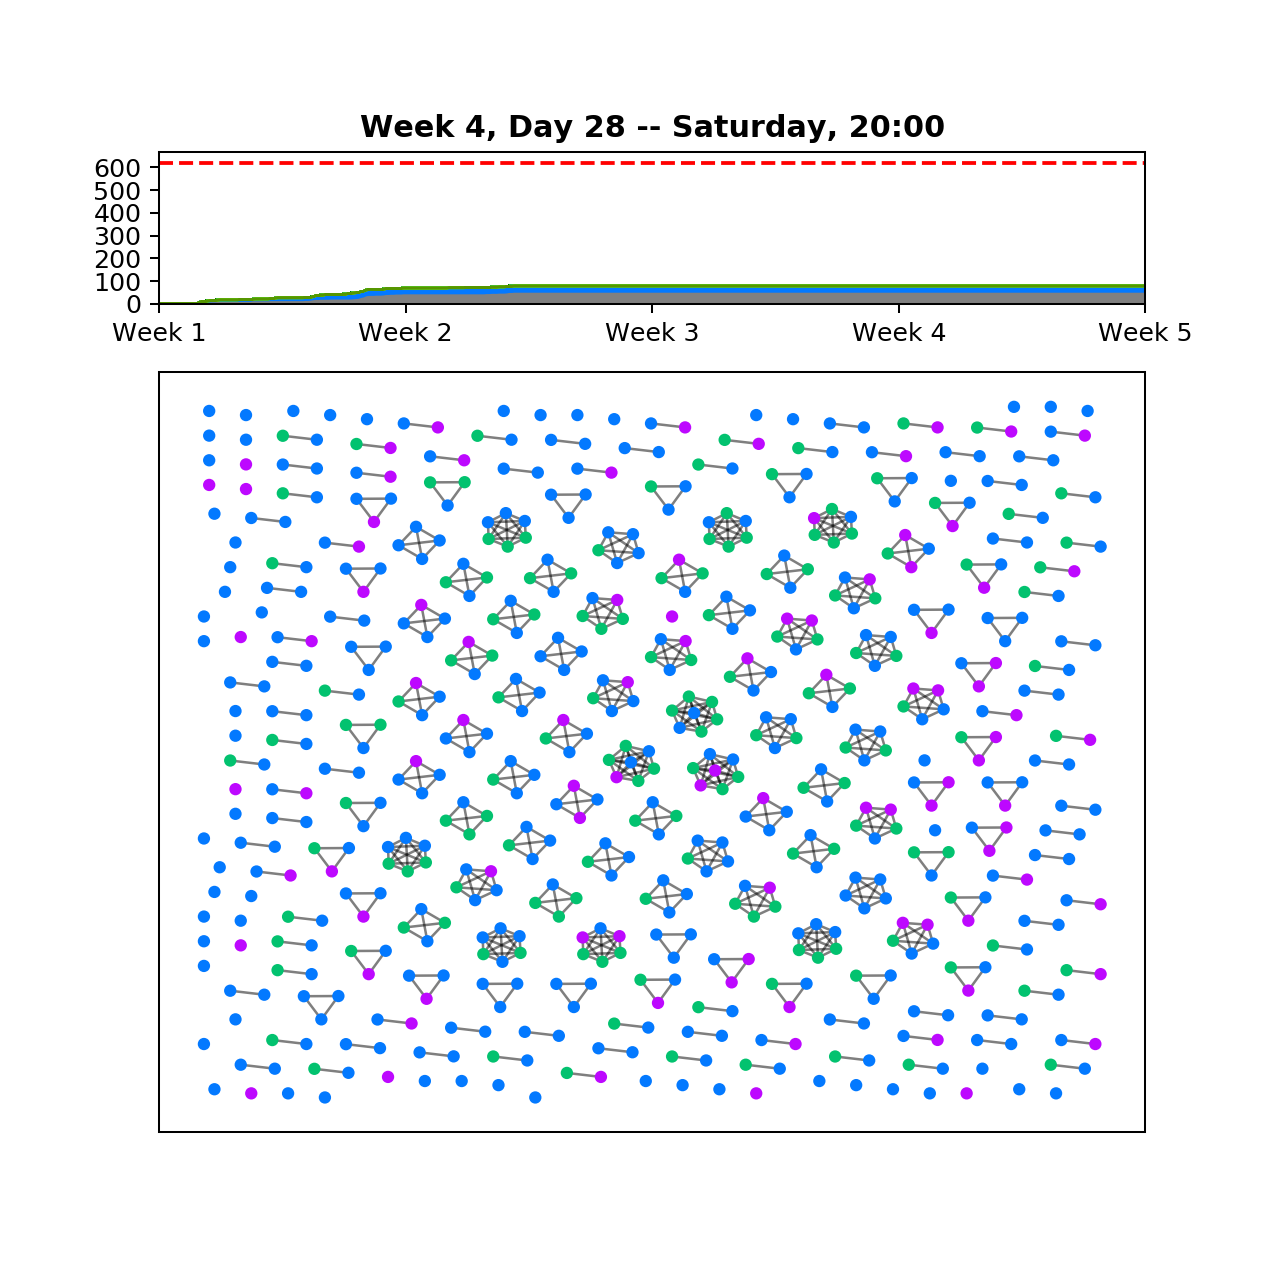

In [215]:
G = clear_all_node_attributes(G, ['time'])
incubating = set()
presymp = set()
symp = set()
recovered = set()

# Get the people to seed the infection
np.random.seed(131)
seed_persons = np.random.choice(range(person_idx), size=num_to_seed, replace=False) 
incubating.update(seed_persons)
nx.set_node_attributes(G, {i:{'time':(0,7)} for i in seed_persons})

# Get the people who may go to large gatherings and who may socialize one-on-one
large_gath_cand = np.random.choice(range(person_idx), replace=False, size=int(round(person_idx*group_social_prop)))
large_gath_cand_dict = {i:0 for i in large_gath_cand}

solo_cand = np.random.choice(range(person_idx), replace=False, size=int(round(person_idx*solo_social_prop)))
solo_cand_dict = {i:0 for i in solo_cand}


# Create the plot object
fig, (ax1, ax2) = plt.subplots(2, figsize=(7,7), gridspec_kw={'height_ratios': [1, 5], 'hspace': 0.15})
ax1.clear()
ax2.clear()

num_timesteps = get_num_timesteps(num_weeks, time_delta)
ax1.set_ylim([0,person_idx+50])
ax1.set_xlim([0, get_num_timesteps(num_weeks, time_delta)])
ax1.axhline(person_idx+1, linestyle='--', color='red')

ax1.set_yticks(np.arange(0, person_idx+50, 100))
ax1.set_xticks(np.arange(0, get_num_timesteps(num_weeks, time_delta)+1, num_timesteps/(num_weeks)))
ax1.set_xticklabels(["Week {}".format(i+1) for i in range(num_weeks+1)])

ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

writer = ani.PillowWriter(fps=6, metadata=dict(artist='Jack Barbey'))
#writer = ani.FFMpegWriter(fps=5, metadata=dict(artist='Jack Barbey'))

animation = ani.FuncAnimation(fig, animate, frames=gen_daytime(num_weeks, time_delta),
                                         interval=1, repeat=False, save_count=10000, blit=True,
                                         fargs=(G, run_id, incubating, presymp, symp, recovered))
animation.save(run_id+'.gif', writer=writer)


In [74]:
print('Mean small social gatherings per person, per week: {:.2f} ({})   '.format(
        sum(solo_cand_dict.values())/len(solo_cand_dict)/num_weeks if len(solo_cand_dict)>0 else 0, run_id))
print('Mean large social gatherings per person, per week: {:.2f} ({})    '.format(
 sum(large_gath_cand_dict.values())/len(large_gath_cand_dict)/num_weeks if len(large_gath_cand_dict)>0 else 0, run_id))

Mean small social gatherings per person, per week: 0.00 (no_social_schools_halfway)   
Mean large social gatherings per person, per week: 0.00 (no_social_schools_halfway)    


In [185]:
# Save all of the case trajectories
with open('cumulative_cases.pickle', 'wb') as handle:
    pickle.dump(cumulative_cases, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot all the trajectories 

In [216]:
# Load in saved case trajectories
with open(r"cumulative_cases.pickle", "rb") as input_file:
    cumulative_cases_loaded = pickle.load(input_file)

In [224]:
final_counts = {}
for run_id in cumulative_cases:
    final_counts[run_id] = max(sum([np.array(i) for i in cumulative_cases[run_id].values()]))

In [225]:
final_counts

{'essential_only': 79,
 'all_normal': 589,
 '10%_group': 161,
 '10%_group_80%_small': 354,
 '80%_small': 224,
 'schools_essential': 363,
 '100%_solo': 342,
 '10%_both_social_schools': 389,
 'no_social_schools_halfway': 393,
 'no_social_schools_halfway_success': 81}

<IPython.core.display.Javascript object>


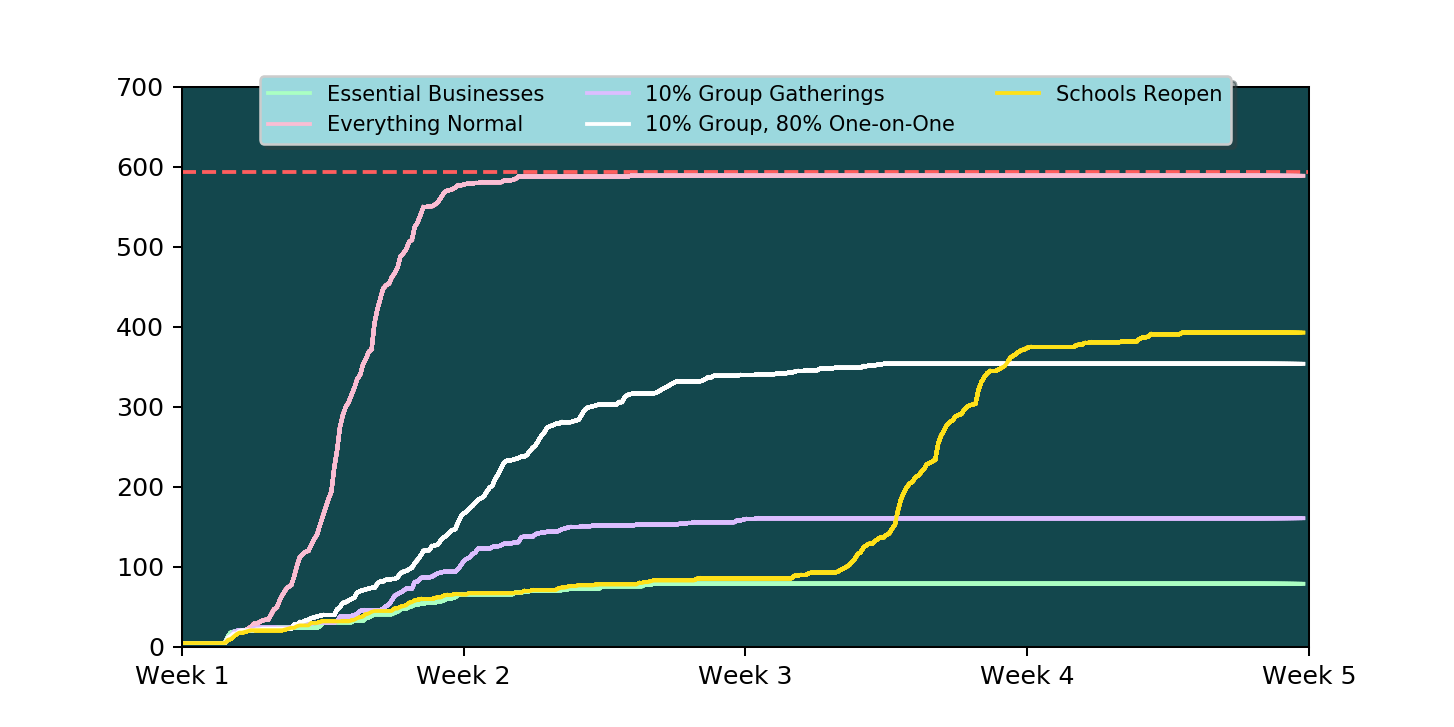

In [205]:
def plot_trajectories(step, cumulative_cases, include, names):
    
    first_pass = False
    
    if include == 'all':
        include = cumulative_cases.keys()
        
    for run_id, name in zip(include, names):
        
        if run_id not in colors_mapped:
            color = colors.pop()
            colors_mapped[run_id] = color
            first_pass = True
            
        color = colors_mapped[run_id]
        
        total_cases = sum([np.array(i) for i in cumulative_cases[run_id].values()])
        
        ax.plot(total_cases[:step], color=color, label=name)
        
    if first_pass: 
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, .88),
          ncol=3, fancybox=True, shadow=True, fontsize='small', facecolor='#9bd8de')
        

fig, ax = plt.subplots(1, figsize=(8,4))
ax.set_facecolor('#13474d')
timesteps = get_num_timesteps(num_weeks, time_delta)
include = ['essential_only','all_normal','10%_group','10%_group_80%_small','no_social_schools_halfway']
names = ['Essential Businesses', 'Everything Normal', '10% Group Gatherings', 
         '10% Group, 80% One-on-One', 'Schools Reopen']

ax.set_ylim([0,person_idx+50])
ax.set_xlim([0, get_num_timesteps(num_weeks, time_delta)])
ax.axhline(final_counts['all_normal']+5, linestyle='--', color='#ff5e5e')

ax.set_yticks(np.arange(0, person_idx+150, 100))
ax.set_xticks(np.arange(0, get_num_timesteps(num_weeks, time_delta)+1, num_timesteps/(num_weeks)))
ax.set_xticklabels(["Week {}".format(i+1) for i in range(num_weeks+1)])

colors = set(['#ffe119', '#ffffff', '#dcbeff', '#aaffc3', '#fabed4'])
colors_mapped = {}

writer = ani.PillowWriter(fps=24, metadata=dict(artist='Jack Barbey'))
animation = ani.FuncAnimation(fig, plot_trajectories, frames=timesteps,
                              interval=10, repeat=False, save_count=10000, blit=False,
                              fargs=(cumulative_cases, include, names))
animation.save('trajectories.gif', writer=writer)